# Step 1 — Processing Flanker (fNIRS, SNIRF) — Beginner Tutorial

**Audience:** New users of fNIRS and MNE/MNE-NIRS

**Purpose:** This notebook walks you through loading SNIRF files, inspecting and cleaning annotations, epoching task data, building a GLM design matrix, estimating task effects, visualizing evoked responses, and exporting tidy results. All original code is preserved.

---
### Learning objectives
- Understand what SNIRF files contain and how MNE loads them
- Clean and interpret task annotations → events
- Epoch data around task blocks and inspect HbO/HbR
- Build a first-level GLM design matrix and fit a simple GLM
- Visualize evoked responses and export tidy tables

---
### How to run this notebook
1. **Install packages** (run in a terminal):
   ```bash
   pip install mne mne-nirs nilearn pandas numpy matplotlib tqdm
   ```
2. **Expected inputs:** SNIRF files (`.snirf`) exported from your acquisition software, organized in a folder you point to in the code.
3. **Outputs:** This notebook writes CSVs and figures into a dated `export/YYYY-MM-DD/` folder.
4. **Hardware tips:** Plotting and GLM steps can be memory intensive; close other apps if you run into memory errors.

---
### Table of Contents
- [Step 0: Setup — imports & configuration](#step-0-setup)
- [Step 1: Load SNIRF data](#step-1-load)
- [Step 2: Attach subject metadata](#step-2-meta)
- [Step 3: Annotations → events](#step-3-ann)
- [Step 4: Epoching by condition](#step-4-epoch)
- [Step 5: Visualizing evoked responses](#step-5-evoked)
- [Step 6: GLM design & estimation](#step-6-glm)

---
### Quick background (for beginners)
- **fNIRS basics:** fNIRS uses light to estimate changes in blood oxygenation near the cortical surface. Two key signals are **HbO** (oxygenated hemoglobin) and **HbR** (deoxygenated hemoglobin).
- **SNIRF files:** A standard format that stores raw light intensity, sensor geometry (sources/detectors), wavelengths, sampling rate, and annotations (task markers).
- **Long vs short channels:** Short-separation channels capture superficial physiology; long-separation channels are more sensitive to cortex.
- **Annotations & events:** Task markers (start/end of blocks) are stored as annotations; we convert them into **events** to epoch data and build designs.
- **Epochs & evoked responses:** Epochs segment continuous data around events; averaging epochs yields **evoked** responses for each condition.
- **GLM:** A statistical model testing whether the time course of the data follows the expected task timing (design matrix). Betas (weights) and t-values quantify effects.

## <a id='step-0-setup'></a>Step 0: Setup — imports & configuration (MNE/MNE-NIRS)

In [1]:
# general dependencies for Python and MNE (Python native fNIRS wavelet analysis)
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress
from tqdm import tqdm
import random
from pprint import pprint
from collections import defaultdict

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import io
from copy import copy
from collections import OrderedDict
import requests


from nilearn.plotting import plot_design_matrix
from mne.viz import plot_compare_evokeds

from datetime import datetime

import mne_nirs
from mne.io import read_raw_nirx, read_raw_snirf
from mne_nirs.channels import get_long_channels, get_short_channels, picks_pair_to_idx
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

from mne.viz import plot_compare_evokeds
from copy import deepcopy

plt.rcParams["figure.figsize"] = (8,4)

%matplotlib inline

In [2]:
fnames = [x[0] for x in os.walk('/data/1126')][1:]


In [3]:
# Important configuration variables
study_dir = "data/"
participant_num_len = 4 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset
debug = True

In [4]:
# make a list of all matching session paths for each subject
session_dirs = [d for d in glob(os.path.join(study_dir, "*.snirf"))]


subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [5]:
subjects

['1253', '1139', '1202', '1126', '1264']

### Displaying Session Directories

- **Objective**: Simply outputs the list of session directories to double check that our paths are correctly and we are refering to the right participants and files

In [6]:
session_dirs

['data/1202.snirf',
 'data/1139.snirf',
 'data/1264.snirf',
 'data/1126.snirf',
 'data/1253.snirf']

### Counting Session Directories
- **Objective**: This line of code calculates the total number of session directories identified in the previous step. This is a proxy for how many participants we have in our files. This number does not include the families with only one of the members wearing the cap.

In [7]:
len(subjects)

5

## <a id='step-1-load'></a>Step 1: Load SNIRF data

MNE reads SNIRF files and manages fNIRS channel metadata. MNE-NIRS adds utilities for fNIRS-specific processing.

In [8]:
#pip install mne

import os
import mne

# Initialize two empty lists to store results
scans = []              # Will hold all successfully loaded SNIRF recordings (Raw objects)
successful_load = []    # Will store the subject IDs for which loading succeeded

# Loop over every SNIRF file path found in session_dirs
for snirf_file in session_dirs:
    try:
        # --- Extract a subject ID from the file name ---
        # os.path.basename() → gets filename only (e.g., "sub-001_task.snirf")
        # os.path.splitext() → removes the file extension
        sub = os.path.splitext(os.path.basename(snirf_file))[0]

        # If debug mode is enabled, print which file is being loaded
        if debug:
            print(f"Loading SNIRF: {snirf_file} -> Sub ID: {sub}")

        # --- Load SNIRF file into an MNE Raw object ---
        fnirs_data = mne.io.read_raw_snirf(
            snirf_file, preload=False, verbose="warning" # preload=False keeps data on disk (faster, less memory)& verbose="warning" suppresses info messages
        )

        # --- Add subject metadata to the Raw object ---
        # If 'subject_info' is missing, create it as an empty dict
        if fnirs_data.info.get('subject_info') is None:
            fnirs_data.info['subject_info'] = {}
        # Store the subject ID in the metadata (standard key: 'his_id')
        fnirs_data.info['subject_info']['his_id'] = sub

        # Append the loaded Raw object and subject ID to the tracking lists
        scans.append(fnirs_data)
        successful_load.append(sub)

    # --- Handle files that fail to load gracefully ---
    except Exception as e:
        print(f"Skipping SNIRF {snirf_file} due to error: {e}")
        continue

Loading SNIRF: data/1202.snirf -> Sub ID: 1202
Loading SNIRF: data/1139.snirf -> Sub ID: 1139
Loading SNIRF: data/1264.snirf -> Sub ID: 1264
Loading SNIRF: data/1126.snirf -> Sub ID: 1126
Loading SNIRF: data/1253.snirf -> Sub ID: 1253


In [9]:
scans

[<RawSNIRF | 1202.snirf, 20 x 6353 (813.2 s), ~25 KiB, data not loaded>,
 <RawSNIRF | 1139.snirf, 20 x 6330 (810.2 s), ~25 KiB, data not loaded>,
 <RawSNIRF | 1264.snirf, 20 x 6260 (801.3 s), ~25 KiB, data not loaded>,
 <RawSNIRF | 1126.snirf, 20 x 6553 (838.8 s), ~25 KiB, data not loaded>,
 <RawSNIRF | 1253.snirf, 20 x 6217 (795.8 s), ~25 KiB, data not loaded>]

Codes that were succesfully loaded:

In [10]:
print(successful_load)

['1202', '1139', '1264', '1126', '1253']


Codes that were NOT succesfully loaded:

In [11]:
failed_load = []

soi = [os.path.splitext(f)[0] for f in os.listdir(study_dir) if f.endswith(".snirf")]

for subject in soi:
    subj_id = subject[-participant_num_len:] 
    if subj_id not in successful_load:
        failed_load.append(subject)

failed_load

[]

In [12]:
# --- Access channel names from the third successfully loaded SNIRF file ---
# MNE Raw objects store channel labels (e.g., 'S1_D1 hbo', 'S1_D1 hbr', etc.)
# This command returns a list of all channel names for inspection.
scans[2].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

## Viewing location of sensors over brain surface

Here we validate that the location of sources-detector pairs and channels are in the expected locations. Source-detector pairs are shown as lines between the optodes, channels (the mid point of source-detector pairs) are optionally shown as orange dots. Source are optionally shown as red dots and detectors as black.

In [13]:
from mne.datasets import fetch_fsaverage

# 1) Ensure fsaverage is available
subjects_dir = os.path.expanduser("~/mne_data")
os.makedirs(subjects_dir, exist_ok=True)
fetch_fsaverage(subjects_dir=subjects_dir, verbose=False)  # one-time

# 2) Pick one of your loaded Raw objects
random_scan = random.choice(scans)

# 3) Visualize sensors on the fsaverage cortical surface
brain = mne.viz.Brain("fsaverage", 
                      subjects_dir=subjects_dir, 
                      background="w", 
                      cortex="0.5")
brain.add_sensors(
    random_scan.info,
    trans="fsaverage",                    # <-- template mapping
    fnirs=["pairs", "sources", "detectors"],
)
brain.show_view(azimuth=20, elevation=60, distance=400)


Using pyvistaqt 3d backend.
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
Channel types::	fnirs_cw_amplitude: 20


## <a id='step-2-meta'></a>Step 2: Attach subject metadata

Attach a subject identifier into `raw.info['subject_info']['his_id']` so every downstream result can be traced back to a participant.

In [14]:
#When you initially check annotations, you will notice a large number of STOP annotations (12 in our case) that needed to be removed
scans[0].annotations

<Annotations | 21 segments: 1.0 (21)>

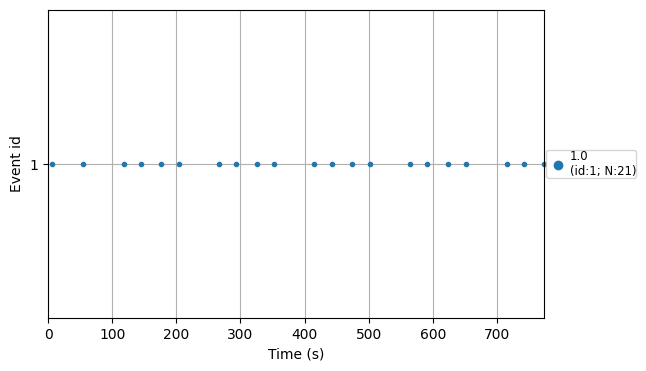

Text(0.5, 0.98, 'Random Subject: 1253')

In [15]:
import random

# --- Check that at least one SNIRF scan was successfully loaded ---
if not scans:
    raise RuntimeError(
        "No scans loaded. Check the study_dir path, file extensions (.snirf), "
        "and permissions. See printed diagnostics above."
    )

# --- Randomly pick one loaded scan to visualize or inspect ---
random_scan = random.choice(scans)

# --- Retrieve subject ID metadata from the selected Raw object ---
subj_id = random_scan.info.get("subject_info", {}).get("his_id", "unknown")

# --- Extract events and event dictionary from the annotations ---
# mne.events_from_annotations() converts MNE annotations into discrete events.
events, event_dict = mne.events_from_annotations(random_scan, verbose=False)

# --- Plot the extracted events for visual inspection ---
# plot_events() displays event timing relative to the sampling frequency (sfreq).
fig = mne.viz.plot_events(
    events,
    event_id=event_dict,
    sfreq=random_scan.info["sfreq"]
)

# Add a figure title showing which subject was plotted.
fig.suptitle(f"Random Subject: {subj_id}")



In [16]:
scans[2].annotations

<Annotations | 6 segments: 1.0 (6)>

In [17]:
scans[1].annotations.to_data_frame()

onset  duration description
0  2022-09-18 16:15:00.992       1.0         1.0
1  2022-09-18 16:15:39.392       1.0         1.0
2  2022-09-18 16:16:42.368       1.0         1.0
3  2022-09-18 16:17:09.504       1.0         1.0
4  2022-09-18 16:17:41.120       1.0         1.0
5  2022-09-18 16:18:08.256       1.0         1.0
6  2022-09-18 16:19:11.232       1.0         1.0
7  2022-09-18 16:19:38.368       1.0         1.0
8  2022-09-18 16:20:09.856       1.0         1.0
9  2022-09-18 16:20:36.992       1.0         1.0
10 2022-09-18 16:21:40.096       1.0         1.0
11 2022-09-18 16:22:07.488       1.0         1.0
12 2022-09-18 16:22:38.976       1.0         1.0
13 2022-09-18 16:23:06.112       1.0         1.0
14 2022-09-18 16:24:09.216       1.0         1.0
15 2022-09-18 16:24:36.352       1.0         1.0
16 2022-09-18 16:25:07.840       1.0         1.0
17 2022-09-18 16:25:36.896       1.0         1.0
18 2022-09-18 16:26:39.872       1.0         1.0
19 2022-09-18 16:27:07.008       1.0         1.0
20 2022-09-18 16:27:38.624       1.0         1.0

## <a id='step-3-ann'></a>Step 3: Annotations → events (clean & structure markers)

Inspect, clean, and relabel annotations to define condition blocks (e.g., `directional`, `nondirectional`). We’ll also handle edge cases (e.g., odd numbers of triggers) so events pair cleanly (start/end).


> **Why clean annotations?** GLMs and epoching expect **paired** starts/ends. Mismatched or missing markers can create odd-length blocks and misleading averages.

In [18]:
# Initialize empty containers for results
records = []   # Will store metadata about each valid annotation block (subject ID, onset, duration, label)
bads = []      # Will record indices of scans that fail during processing

# Iterate over all loaded MNE Raw scans
for i, scan in enumerate(scans):
    try:
        # --- Step 0: Check if the scan has annotations ---
        # If no annotations exist or list is empty, skip this scan
        if scan.annotations is None or len(scan.annotations) == 0:
            print(f"No annotations in scan {i}")
            continue

        # Print current annotations for inspection
        print(f"\nScan {i} - Original annotations:")
        print(scan.annotations)

        # Store current annotation details for convenience
        descriptions = scan.annotations.description
        onsets = scan.annotations.onset

        # --- Step 1: Remove the first annotation (task-start marker) ---
        # Skip scans with fewer than two annotations (nothing meaningful to segment)
        if len(descriptions) < 2:
            print(f"Scan {i} has fewer than 2 triggers; skipping.")
            continue

        scan.annotations.delete(0)

        # --- Step 2: Handle scans with an odd number of triggers ---
        # Each block is defined by a start and end trigger, so an odd number breaks pairing.
        if len(scan.annotations) % 2 != 0:
            print(f"Scan {i} has an odd number of triggers after removing the first; dropping the last trigger.")
            scan.annotations.delete(len(scan.annotations) - 1)

        # --- Step 3: Compute block-level metadata ---
        new_descriptions = []  # Updated labels for each block
        new_onsets = []        # Start times of each block
        new_durations = []     # Computed durations (end - start)

        # Divide triggers into start/end pairs
        block_num = len(scan.annotations) // 2
        for j in range(block_num):
            start_idx = 2 * j
            end_idx = start_idx + 1

            # Extract start and end times
            start_onset = scan.annotations.onset[start_idx]
            end_onset = scan.annotations.onset[end_idx]
            duration = end_onset - start_onset

            # Alternate block labels: “directional”, “nondirectional”
            block_type = 'directional' if j % 2 == 0 else 'nondirectional'
            label = f"{block_type}"

            # Save new annotation details
            new_descriptions.append(label)
            new_onsets.append(start_onset)
            new_durations.append(duration)

            # Record block metadata in the global list
            records.append({
                'subject_id': scan.info['subject_info']['his_id'],
                'onset': start_onset,
                'duration': duration,
                'annotation': label,
                'block_type': block_type
            })

        # --- Step 4: Replace existing annotations with new block definitions ---
        scan.set_annotations(
            mne.Annotations(
                onset=new_onsets,
                duration=new_durations,
                description=new_descriptions
            )
        )

        print(f"Updated annotations for scan {i}:")
        print(scan.annotations)

    # --- Error handling: store failing scan indices for cleanup ---
    except Exception as e:
        print(f"Failed on scan {i} with error: {e}")
        bads.append(i)

# --- Step 5: Remove failed scans from the list ---
# Deleting in reverse order prevents index shifting issues.
for i in sorted(bads, reverse=True):
    del scans[i]


Scan 0 - Original annotations:
<Annotations | 21 segments: 1.0 (21)>
Updated annotations for scan 0:
<Annotations | 10 segments: directional (5), nondirectional (5)>

Scan 1 - Original annotations:
<Annotations | 21 segments: 1.0 (21)>
Updated annotations for scan 1:
<Annotations | 10 segments: directional (5), nondirectional (5)>

Scan 2 - Original annotations:
<Annotations | 6 segments: 1.0 (6)>
Scan 2 has an odd number of triggers after removing the first; dropping the last trigger.
Updated annotations for scan 2:
<Annotations | 2 segments: directional (1), nondirectional (1)>

Scan 3 - Original annotations:
<Annotations | 20 segments: 1.0 (20)>
Scan 3 has an odd number of triggers after removing the first; dropping the last trigger.
Updated annotations for scan 3:
<Annotations | 9 segments: directional (5), nondirectional (4)>

Scan 4 - Original annotations:
<Annotations | 21 segments: 1.0 (21)>
Updated annotations for scan 4:
<Annotations | 10 segments: directional (5), nondirect

## Visualizing the events

In [19]:
scans

[<RawSNIRF | 1202.snirf, 20 x 6353 (813.2 s), ~25 KiB, data not loaded>,
 <RawSNIRF | 1139.snirf, 20 x 6330 (810.2 s), ~25 KiB, data not loaded>,
 <RawSNIRF | 1264.snirf, 20 x 6260 (801.3 s), ~25 KiB, data not loaded>,
 <RawSNIRF | 1126.snirf, 20 x 6553 (838.8 s), ~25 KiB, data not loaded>,
 <RawSNIRF | 1253.snirf, 20 x 6217 (795.8 s), ~25 KiB, data not loaded>]

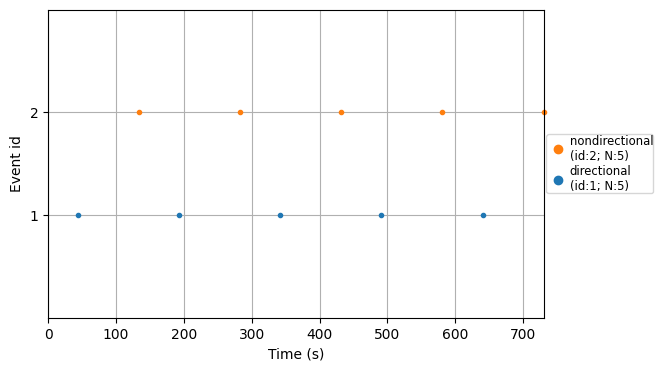

Text(0.5, 0.98, 'Random Subject: 1139')

In [20]:
import random

if not scans:
    raise RuntimeError(
        "No scans loaded. Check the study_dir path, file extensions (.snirf), "
        "and permissions. See printed diagnostics above."
    )

random_scan = random.choice(scans)
subj_id = random_scan.info.get("subject_info", {}).get("his_id", "unknown")

# if you want events next:
events, event_dict = mne.events_from_annotations(random_scan, verbose=False)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=random_scan.info["sfreq"])
fig.suptitle(f"Random Subject: {subj_id}")


## Check the new labels

In [21]:
scans[2].annotations

<Annotations | 2 segments: directional (1), nondirectional (1)>

In [22]:
scans[1].annotations.to_data_frame()

onset  duration     description
0 2022-09-18 16:15:39.392    62.976     directional
1 2022-09-18 16:17:09.504    31.616  nondirectional
2 2022-09-18 16:18:08.256    62.976     directional
3 2022-09-18 16:19:38.368    31.488  nondirectional
4 2022-09-18 16:20:36.992    63.104     directional
5 2022-09-18 16:22:07.488    31.488  nondirectional
6 2022-09-18 16:23:06.112    63.104     directional
7 2022-09-18 16:24:36.352    31.488  nondirectional
8 2022-09-18 16:25:36.896    62.976     directional
9 2022-09-18 16:27:07.008    31.616  nondirectional

Using matplotlib as 2D backend.


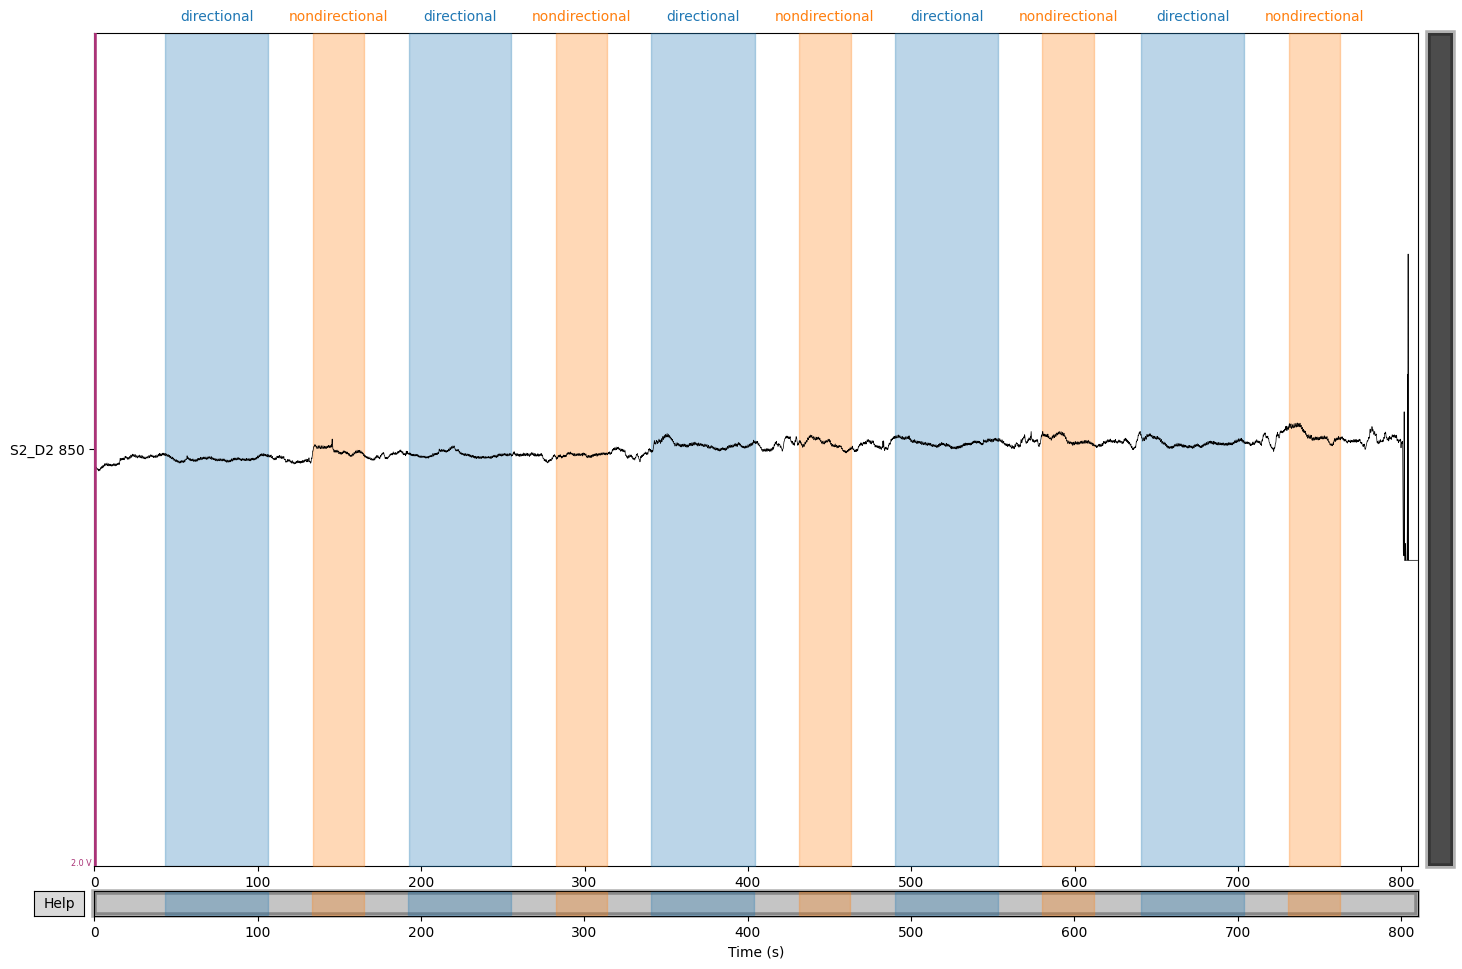

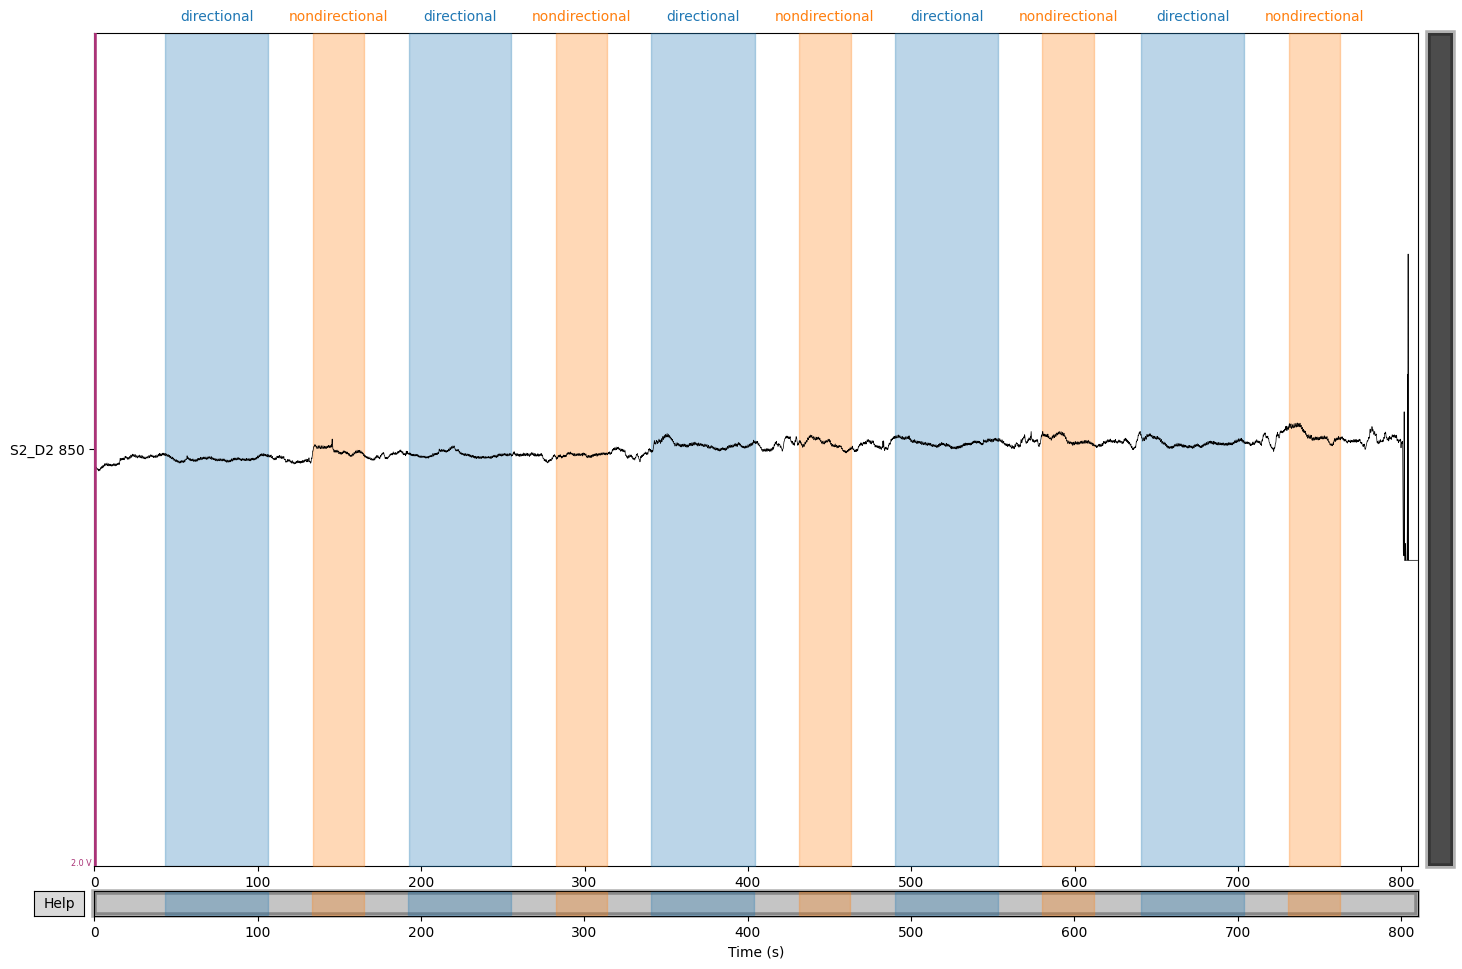

In [23]:
# example Block plot for 1200 seconds
scans[1].copy().pick(['S2_D2 850']).plot(duration=1200, scalings=1)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD/PSU-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair
- Beer Lambert Law to Convert to Haemoglobin
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [24]:
# Make a list where the preprocessed scans will go
pps = []

# For each individual scan in scans
for scan in scans:
    
    # Convert to optical density
    raw_od = mne.preprocessing.nirs.optical_density(scan)
    print(raw_od.info['subject_info']['his_id'])

    # Scalp coupling index
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
    raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))

    # Bad channel labelling
    if len(raw_od.info['bads']) > 0:
        print("--->>>> Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])

    # Linear detrend, par example
    # raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, type='linear')

    # Temporal Derivative Distribution Repair (motion correction)
    tddr_od = mne.preprocessing.nirs.tddr(raw_od)
    # print("tddr")
    # tddr_od.plot(
    #     n_channels=len(tddr_od.ch_names),
    #     scalings=0.1,
    #     duration=100,
    #     show_scrollbars=False)

    # Savitzky-Golay filter (optional smoothing)
    # sav_od = tddr_od.copy().savgol_filter(0.5)
    # print("savgol filtering")
    # sav_od.plot(
    #     n_channels=len(sav_od.ch_names),
    #     scalings=0.1,
    #     duration=100,
    #     show_scrollbars=False)

    # Bandpass filtering (before BLL)
    bp_od = tddr_od.filter(0.01, 0.5)
    # print("bandpass")
    # bp_od.plot(
    #     n_channels=len(bp_od.ch_names),
    #     duration=100,
    #     scalings=0.1,
    #     show_scrollbars=False)

    # Short Channel Correction (Removed as requested)
    # od_sc_corrected = mne_nirs.signal_enhancement.short_channel_regression(bp_od)

    # Haemoglobin conversion (using bandpass-filtered data)
    haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
    # print("haemo")
    # haemo.plot(
    #     n_channels=len(haemo.ch_names),
    #     duration=100,
    #     scalings=0.0001,
    #     show_scrollbars=False)

    # Optional PSD plot
    # print("PSD")
    # haemo.plot_psd(average=True)

    # Bandpass filter after haemoglobin conversion
    haemo_bp = haemo.copy().filter(
        0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)
    # haemo_bp.plot(
    #     n_channels=len(haemo_bp.ch_names),
    #     duration=100,
    #     scalings=0.0001,
    #     show_scrollbars=False)

    # Append final preprocessed scan
    pps.append(haemo_bp)


Reading 0 ... 6352  =      0.000 ...   813.056 secs...
1202
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 2579 samples (330.112 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth

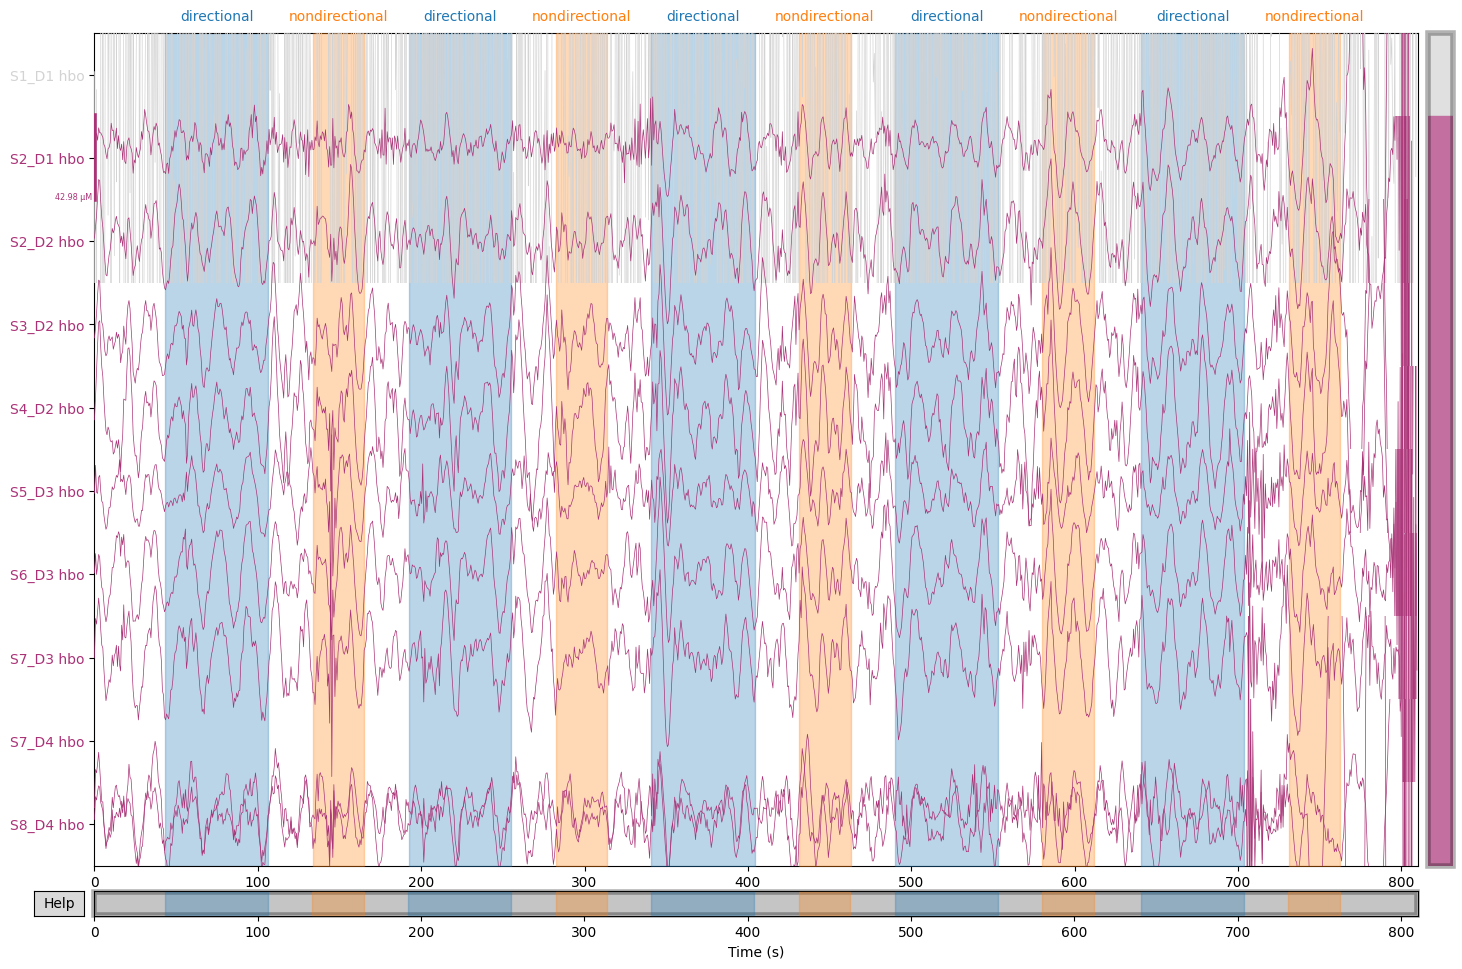

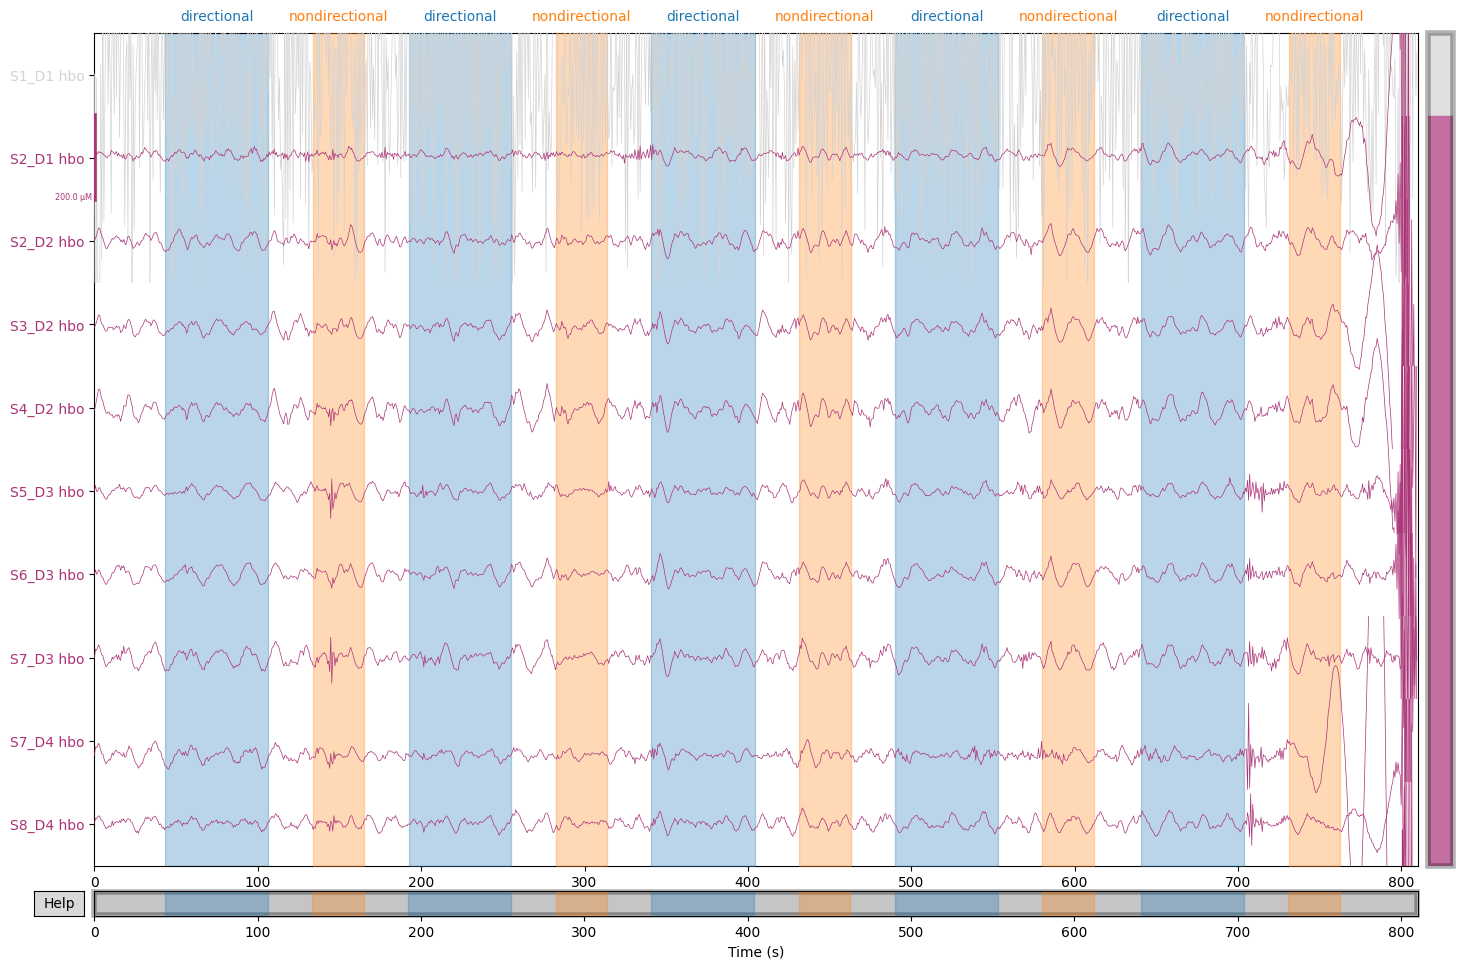

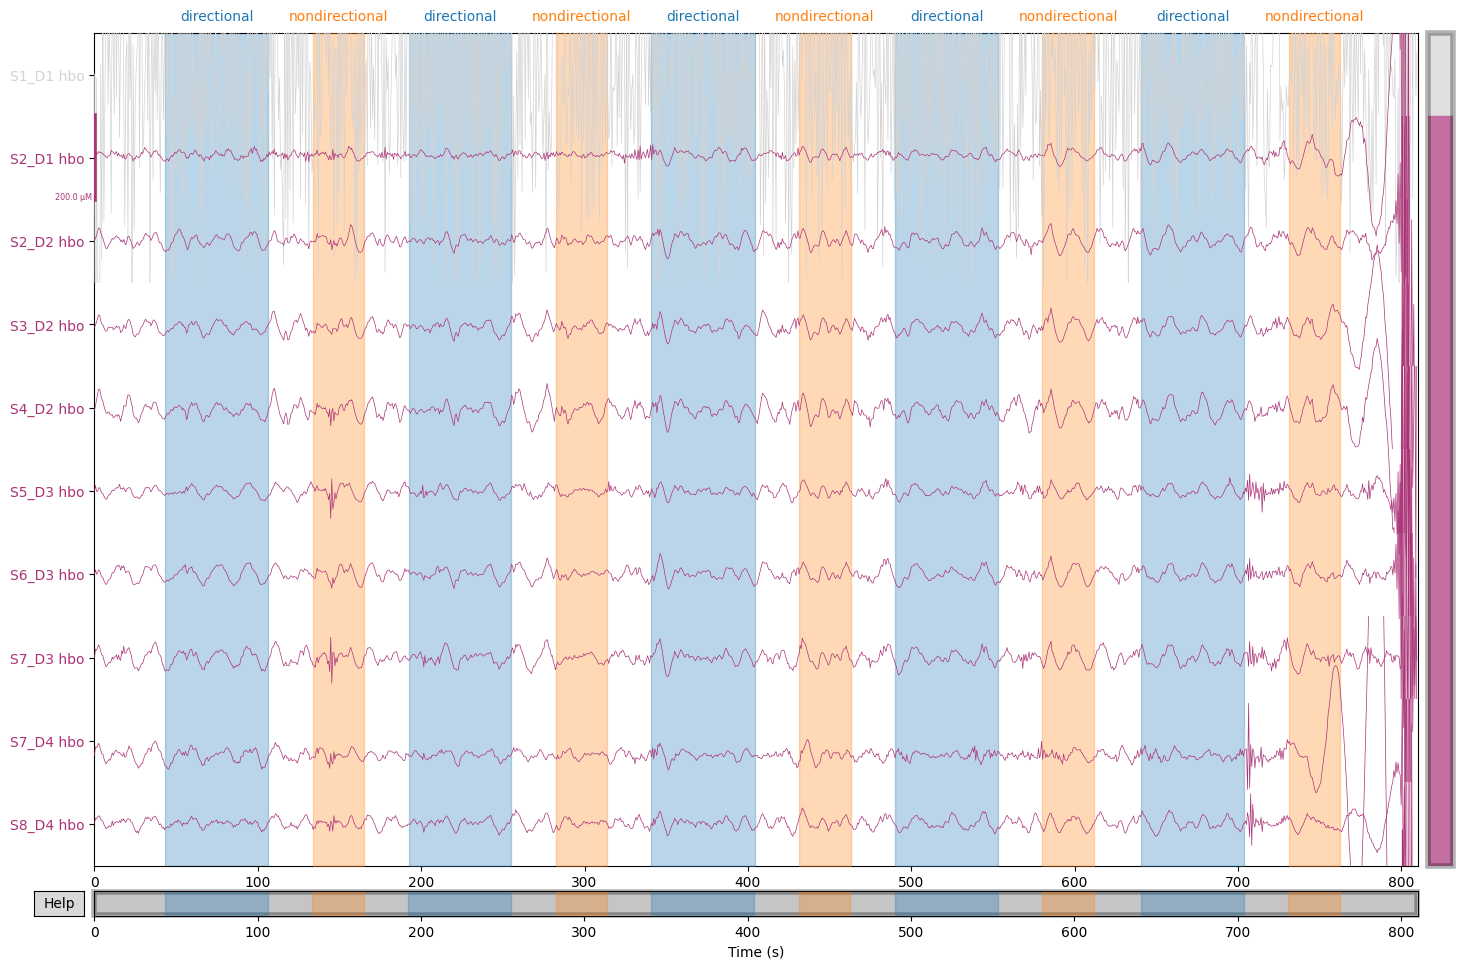

In [25]:
# example plot for 3000 seconds
pps[1].copy().pick(['hbo']).plot(duration=3000, scalings='auto')

raw_vis = pps[1].copy().pick(['hbo'])
#raw_vis.info['bads'] = []  # clear bads for full visualization

raw_vis.plot(
    duration=3000,
    n_channels=len(raw_vis.ch_names),
    scalings=0.0001,
    title='fNIRS hbo signals - all channels',
    show=True
)


In [26]:
sampling_rate = pps[0].info['sfreq']
print(sampling_rate)

7.8125


## <a id='step-4-epoch'></a>Step 4: Epoching by condition

In [27]:
# Define a helper function to epoch a single participant’s hemodynamic (fNIRS) data.
def individual_epoching(raw_haemo, tmax_val):
    """   
    Parameters
    ----------
    raw_haemo : mne.io.Raw
        The continuous (un-epoched) fNIRS dataset containing annotations.
    tmax_val : float
        The end time (in seconds) for each epoch window (relative to event onset).

    Returns
    -------
    raw_haemo : mne.io.Raw
        The same input object (unchanged, for convenience in pipelines).
    epochs : mne.Epochs
        The segmented data structure containing trials aligned to events.
    """

    # --- Extract events from annotation markers ---
    # Converts annotation onsets into discrete event arrays and an event dictionary.
    # Each annotation type becomes a separate condition (event_id).
    events, event_dict = mne.events_from_annotations(
        raw_haemo, verbose=False
    )

    # --- Create epochs (segmented time windows around each event) ---
    # mne.Epochs segments the continuous signal based on these events.
    epochs = mne.Epochs(
        raw_haemo,             # The continuous dataset to segment
        events,                # Event array [sample, 0, event_code]
        event_id=event_dict,   # Mapping of event labels → codes
        tmin=-5,               # Start 5 seconds before each event
        tmax=tmax_val,         # End at the specified window length
        reject=dict(hbo=200e-6),         # Reject epochs with excessive HbO amplitude
        reject_by_annotation=True,       # Respect bad segments marked in annotations
        proj=True,                        # Apply projection operators (if present)
        baseline=(None, 0),               # Apply baseline correction using pre-event interval
        detrend=0,                        # Remove DC offset only (linear detrend off)
        preload=True,                     # Load data into memory for faster access
        verbose=False                     # Suppress console output
    )

    # Return both the unmodified raw object and the new epoch object.
    return raw_haemo, epochs



#### Fixed time for epoching (31.5s)

In [28]:
from collections import defaultdict   # For dictionaries that auto-create empty lists as needed
from pprint import pprint             # For cleaner, indented output in the console

# --- Define condition durations (used elsewhere in your pipeline) ---
condition_durations = {
    "directional": 31.5,
    "nondirectional": 31.5
}

# --- Initialize a dictionary to store averaged data ---
evoked_subjects = defaultdict(list)

# --- Loop over all participant Raw objects ---
for sub in pps:
    # Extract subject ID if available; otherwise assign 'unknown'
    subj_id = sub.info['subject_info']['his_id'] if sub.info.get('subject_info') else 'unknown'

    # Run the individual epoching procedure to obtain segmented data
    # Returns the raw object and corresponding epochs for this participant
    raw_haemo, epochs = individual_epoching(sub, 31.6)

    # --- Loop through all experimental conditions in this subject's epochs ---
    for condition in epochs.event_id:
        # Compute the average (Evoked object) for all trials in this condition
        # Each Evoked represents the mean hemodynamic response for that condition
        evoked_subjects[condition].append(epochs[condition].average())

# --- Display the resulting structure ---
# pprint prints nested dictionaries and lists in a more readable format
pprint(evoked_subjects)


defaultdict(<class 'list'>,
            {np.str_('directional'): [<Evoked | 'directional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
                                      <Evoked | 'directional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
                                      <Evoked | 'directional' (average, N=1), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
                                      <Evoked | 'directional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
                                      <Evoked | 'directional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>],
             np.str_('nondirectional'): [<Evoked | 'nondirectional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
                                         <Evoked | 'nondirectional' (average, N=4), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,


In [29]:
import os
from datetime import datetime
from copy import deepcopy
from pprint import pprint

import numpy as np
import pandas as pd


# --- Create export directory using today's date ---
today_str = datetime.today().strftime('%Y-%m-%d')   # e.g., "2025-10-27"
export_path = os.path.join("export", today_str)
os.makedirs(export_path, exist_ok=True)

# --- Define output file paths ---
csv_individual = os.path.join(export_path, "epoched_df.csv")
csv_avg = os.path.join(export_path, "epoched_df_avg_percondition.csv")

# --- Initialize an empty DataFrame for individual values ---
df = pd.DataFrame(columns=["record_id", "channel", "condition", "chroma", "tmax", "value"])

# --- Loop through conditions and Evoked objects ---
for condition, evoked_list in evoked_subjects.items():
    for evoked in evoked_list:
        # Extract subject ID
        subj_id = evoked.info.get("subject_info", {}).get("his_id", "unknown")

        # Skip if too many bad channels
        if "bads" in evoked.info and len(evoked.info["bads"]) > 5:
            print(f"⚠ Skipping {subj_id} due to {len(evoked.info['bads'])} bad channels.")
            continue

        # Loop through each channel and select hemoglobin type
        for ch_name in evoked.info["ch_names"]:
            for chroma in ["hbo", "hbr"]:
                if chroma not in ch_name.lower():
                    continue
                try:
                    data = deepcopy(evoked).pick([ch_name])   # Copy to avoid modifying original
                    value = float(data.data.mean() * 1e6)     # Convert mean to µM

                    if value == 0 or np.isnan(value):
                        continue

                    # Add row to dataframe
                    df.loc[len(df)] = {
                        "record_id": subj_id,
                        "channel": ch_name,
                        "chroma": chroma,
                        "condition": condition,
                        "value": value,
                        "tmax": 31.5,
                    }

                except Exception as e:
                    print(f"⚠ Skipping {subj_id}, {condition}, {ch_name}: {e}")
                    continue

# --- Clean and save individual-level data ---
df["value"] = pd.to_numeric(df["value"], errors="coerce")
df.to_csv(csv_individual, index=False)
pprint(df)
print(f"✅ Individual-level CSV saved at: {csv_individual}")

# --- Compute and save averages across conditions ---
df_avg = (
    df.groupby(["record_id", "condition", "chroma", "tmax"], as_index=False)
      .agg(value=("value", "mean"))
)
df_avg.to_csv(csv_avg, index=False)
pprint(df_avg)
print(f"✅ Averaged CSV saved at: {csv_avg}")

# --- Final confirmation ---
print("\nExport summary:")
print(f"- Individual file: {csv_individual}")
print(f"- Averaged file:   {csv_avg}")


    record_id    channel       condition chroma  tmax     value
0        1202  S1_D1 hbo     directional    hbo  31.5  0.650951
1        1202  S1_D1 hbr     directional    hbr  31.5 -2.049098
2        1202  S2_D1 hbo     directional    hbo  31.5 -2.679402
3        1202  S2_D1 hbr     directional    hbr  31.5 -2.825772
4        1202  S2_D2 hbo     directional    hbo  31.5 -5.165599
..        ...        ...             ...    ...   ...       ...
195      1253  S7_D3 hbr  nondirectional    hbr  31.5  3.802416
196      1253  S7_D4 hbo  nondirectional    hbo  31.5 -2.681018
197      1253  S7_D4 hbr  nondirectional    hbr  31.5  1.253642
198      1253  S8_D4 hbo  nondirectional    hbo  31.5 -2.963202
199      1253  S8_D4 hbr  nondirectional    hbr  31.5  2.214481

[200 rows x 6 columns]
✅ Individual-level CSV saved at: export/2025-10-28/epoched_df.csv
   record_id       condition chroma  tmax     value
0       1126     directional    hbo  31.5  3.814253
1       1126     directional    hbr  3

In [30]:
evoked_subjects

defaultdict(list,
            {np.str_('directional'): [<Evoked | 'directional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
              <Evoked | 'directional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
              <Evoked | 'directional' (average, N=1), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
              <Evoked | 'directional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
              <Evoked | 'directional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>],
             np.str_('nondirectional'): [<Evoked | 'nondirectional' (average, N=5), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
              <Evoked | 'nondirectional' (average, N=4), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
              <Evoked | 'nondirectional' (average, N=1), -4.992 – 31.616 s, baseline -4.992 – 0 s, 20 ch, ~70 KiB>,
              <Ev

## <a id='step-5-evoked'></a>Step 5: Visualizing evoked responses

Average epochs to get condition-specific responses and visualize HbO/HbR over time. Comparisons (e.g., dashed vs solid) show differences between conditions.

> **Reading evoked plots:** Solid vs dashed lines can indicate conditions; red/blue often denote HbO/HbR. Look for consistent deflections during task windows compared to baseline.

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


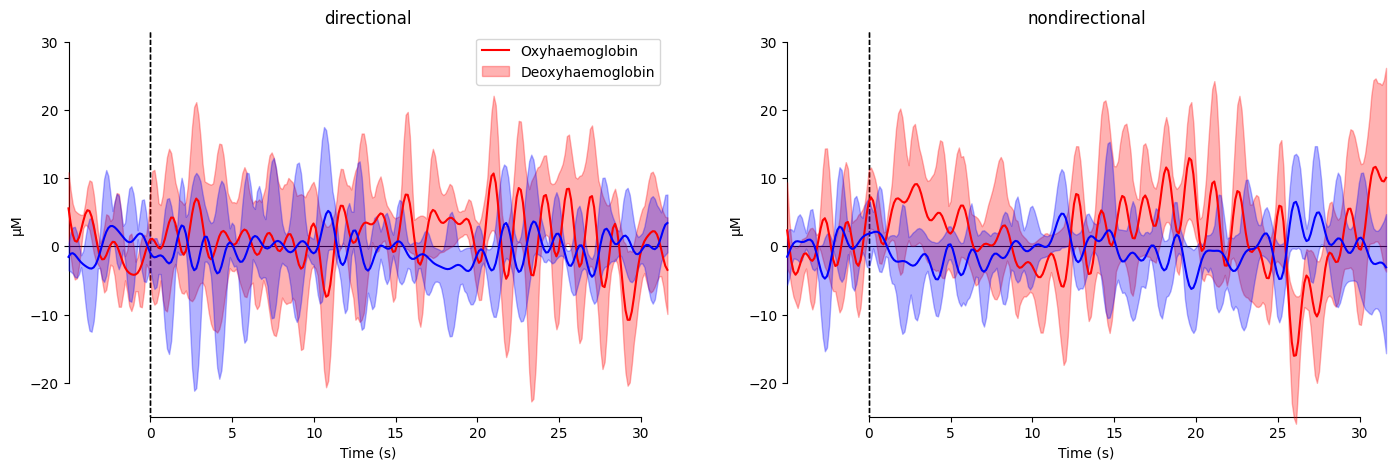

In [31]:
# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(evoked_subjects), figsize=(17, 5))
lims = dict(hbo=[-25, 31.5], hbr=[-25, 31.5])


for pick, color in zip(["hbo", "hbr"], ["r", "b"]):
    for idx, evoked in enumerate(evoked_subjects):
        plot_compare_evokeds(
            {evoked: evoked_subjects[evoked]},
            combine="mean",
            picks=pick,
            axes=axes[idx],
            show=False,
            colors=[color],
            legend=False,
            ylim=lims,
            ci=0.95,
            show_sensors=idx == 2,
        )
        axes[idx].set_title(f"{evoked}")
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

In [32]:
import re
from mne_nirs.channels import picks_pair_to_idx

# Use the SAME info that matches your GLM or your current Raw
info_for_roi = raw_haemo.info   # or: raw_haemo.info

# Discover which (S,D) pairs actually exist (HbO/HbR both)
avail_pairs = set()
for ch_name in info_for_roi['ch_names']:
    m = re.match(r"S(\d+)_D(\d+)\s+(hbo|hbr)$", ch_name)
    if m:
        avail_pairs.add((int(m.group(1)), int(m.group(2))))

print("Available pairs:", sorted(avail_pairs))

# Your desired definitions (edit as needed)
left_desired  = [(1,1), (2,1), (2,2), (3,2), (4,2)]
right_desired = [(5,3), (6,3), (7,3), (7,4), (8,4)]

# Keep only pairs that actually exist
left_valid  = [p for p in left_desired  if p in avail_pairs]
right_valid = [p for p in right_desired if p in avail_pairs]

missing = {
    "Left_missing":  [p for p in left_desired  if p not in avail_pairs],
    "Right_missing": [p for p in right_desired if p not in avail_pairs],
}
if missing["Left_missing"] or missing["Right_missing"]:
    print("⚠️ Missing (not present in data):", missing)

# Build ROI indices (will include both HbO and HbR for those pairs)
rois = dict(
    Left_Hemisphere  = picks_pair_to_idx(info_for_roi, left_valid),
    Right_Hemisphere = picks_pair_to_idx(info_for_roi, right_valid),
)

print("ROI indices:", rois)





Available pairs: [(1, 1), (2, 1), (2, 2), (3, 2), (4, 2), (5, 3), (6, 3), (7, 3), (7, 4), (8, 4)]
ROI indices: {'Left_Hemisphere': [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)], 'Right_Hemisphere': [np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]}


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/bj/k48c5pg95p3f66x8j20kgs2sf68j1h/T/ipykernel_80584/2175144845.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


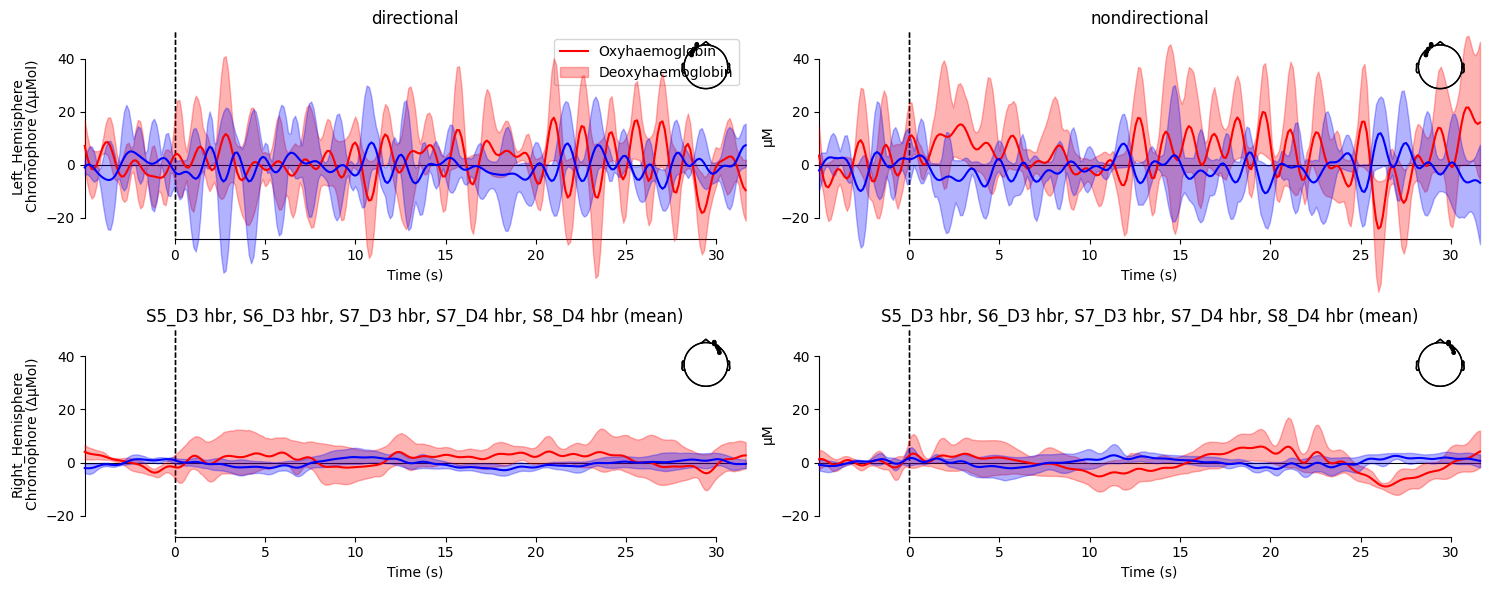

In [33]:
import matplotlib.pyplot as plt
from mne.viz import plot_compare_evokeds
import mne

# rois = {"Left_Hemisphere": [idxs], "Right_Hemisphere": [idxs]}
# all_evokeds_graph = defaultdict(list, {"directional": [Ev1, Ev2, ...], "nondirectional": [Ev1, Ev2, ...]})

# Create figure grid
fig, axes = plt.subplots(
    nrows=len(rois),
    ncols=len(evoked_subjects),
    figsize=(15, 6),
    squeeze=False
)

# Define Y-axis limits per chromophore
lims = dict(hbo=[-28, 50], hbr=[-28, 50])

# Get channel indices for HbO and HbR
example_evoked = next(iter(evoked_subjects.values()))[0]
hbo_all = set(mne.pick_types(example_evoked.info, fnirs="hbo"))
hbr_all = set(mne.pick_types(example_evoked.info, fnirs="hbr"))

# Loop through chromophores, ROIs, and conditions
for chromo, color in zip(["hbo", "hbr"], ["r", "b"]):
    for ridx, roi in enumerate(rois):
        roi_idxs = set(rois[roi])

        # Pick only the right channels for the current chromophore
        if chromo == "hbo":
            picks = sorted(roi_idxs & hbo_all)
        else:
            picks = sorted(roi_idxs & hbr_all)

        for cidx, cond in enumerate(evoked_subjects.keys()):
            evoked_list = evoked_subjects[cond]  # list of Evokeds for this condition

            # Skip if no channels match this chromophore
            if not picks:
                continue

            # Plot the average ± CI for this ROI × condition × chromophore
            plot_compare_evokeds(
                {cond: evoked_list},
                combine="mean",
                picks=picks,
                axes=axes[ridx, cidx],
                colors=[color],
                ci=0.95,
                ylim=lims,
                show=False,
                legend=False,
                show_sensors=True,
            )

            # Remove cluttered auto channel names (e.g., “S5_D3 hbo (mean)”)
            for txt in list(axes[ridx, cidx].texts):
                if "_D" in txt.get_text():
                    txt.set_visible(False)

        # Add row labels for each ROI
        axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")

# Add column titles for each condition
for cidx, cond in enumerate(evoked_subjects.keys()):
    axes[0, cidx].set_title(cond)

# Add a legend like the MNE tutorial
axes[0, 0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"], loc="upper right")

fig.tight_layout()
plt.show()


## Extra fun things

In [34]:
raw_haemo = pps[0].copy()
raw_haemo

<RawSNIRF | 1202.snirf, 20 x 6353 (813.2 s), ~1018 KiB, data loaded>

Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


/Users/jfr5989/opt/anaconda3/envs/new_nirs/lib/python3.13/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


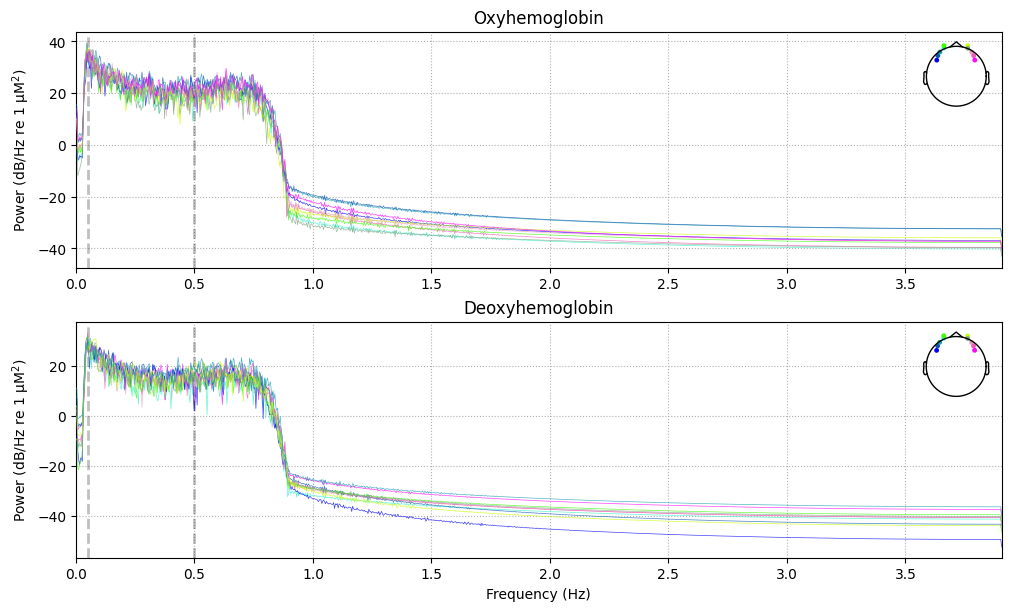

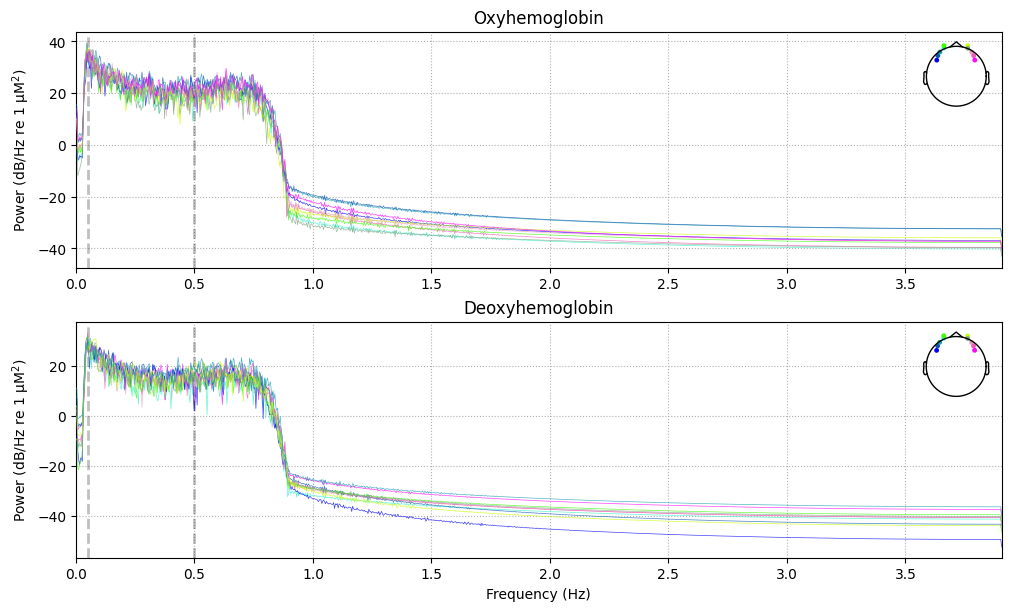

In [35]:

raw_haemo.compute_psd().plot(average=False)

Used Annotations descriptions: [np.str_('directional'), np.str_('nondirectional')]
Not setting metadata
10 matching events found
Setting baseline interval to [-4.992, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 10 events and 286 original time points ...
0 bad epochs dropped
<Epochs | 10 events (all good), -4.992 – 31.488 s (baseline -4.992 – 0 s), ~472 KiB, data loaded,
 np.str_('directional'): 5
 np.str_('nondirectional'): 5>


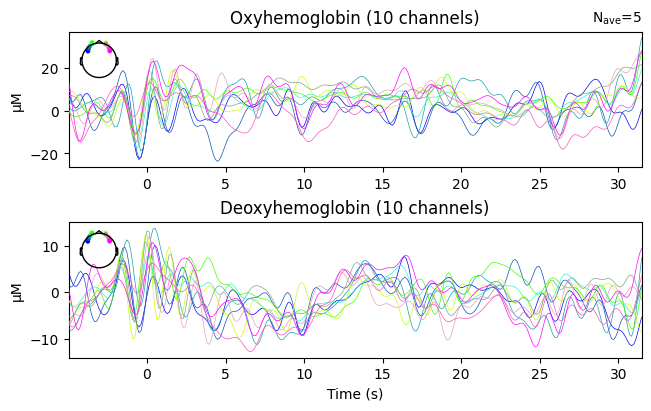

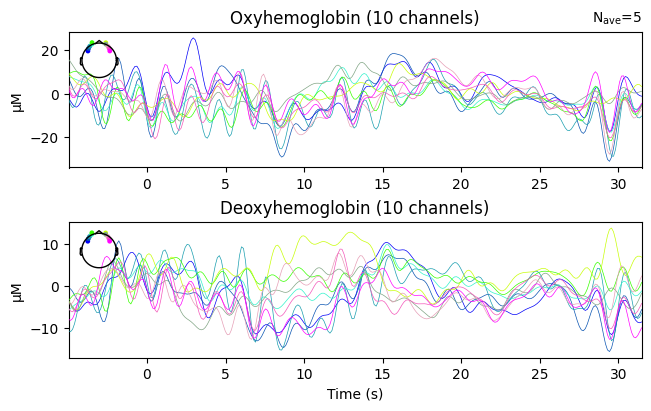

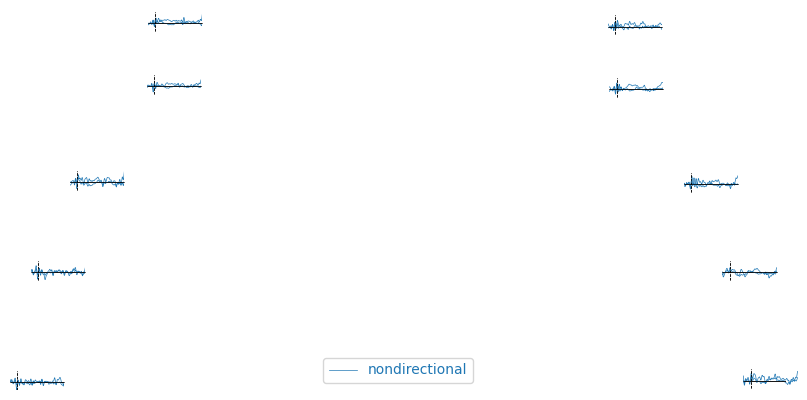

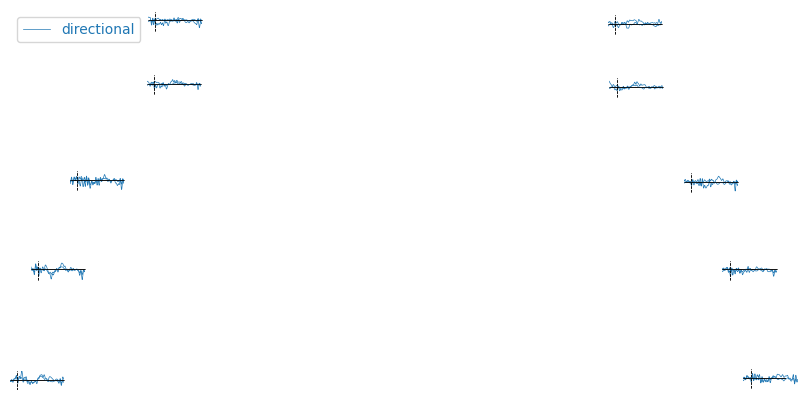

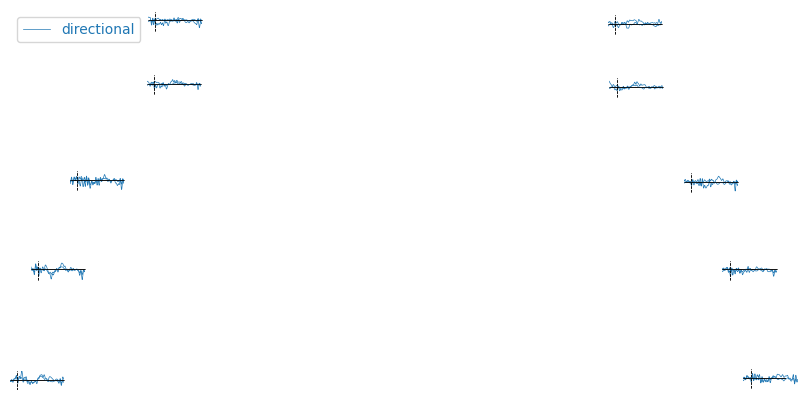

In [36]:
events,event_id = mne.events_from_annotations(raw_haemo)
reject_criteria = dict(hbo=200e-6) 
tmin,tmax = -5,31.5

epochs = mne.Epochs(
    raw_haemo, 
    events=events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    reject_by_annotation=True,
    reject=reject_criteria,
    preload=True
)
pprint(epochs)

#epochs.plot_drop_log()
epochs['nondirectional']
epochs['nondirectional'].average().plot()
epochs['directional'].average().plot()

evoked = epochs['nondirectional'].average()
evoked.plot_topo()

evoked = epochs['directional'].average()
evoked.plot_topo()

In [37]:
pprint(epochs)

<Epochs | 10 events (all good), -4.992 – 31.488 s (baseline -4.992 – 0 s), ~472 KiB, data loaded,
 np.str_('directional'): 5
 np.str_('nondirectional'): 5>


No projector specified for this dataset. Please consider the method self.add_proj.


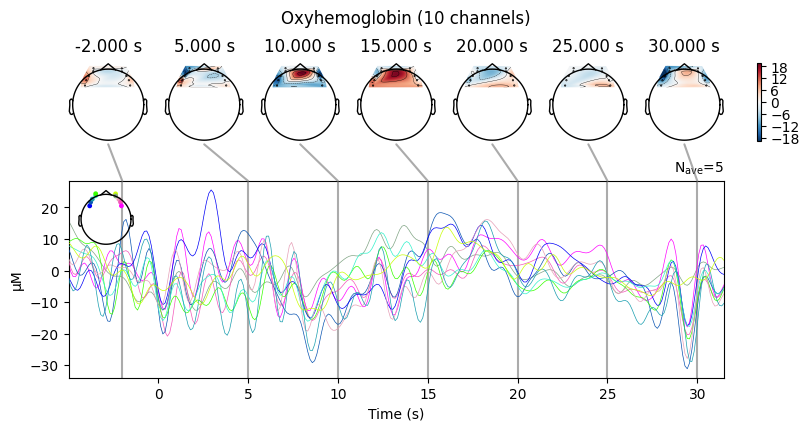

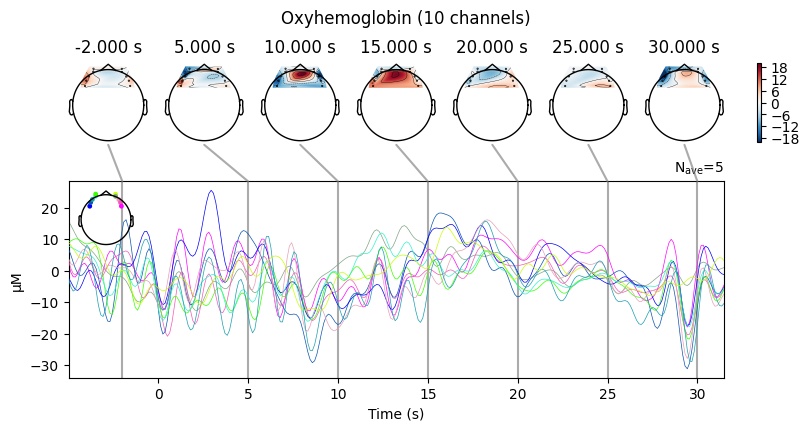

In [38]:
evoked.pick(picks='hbo').plot_joint(times=[-2,5,10,15,20,25,30], topomap_args=dict(extrapolate='local'))

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


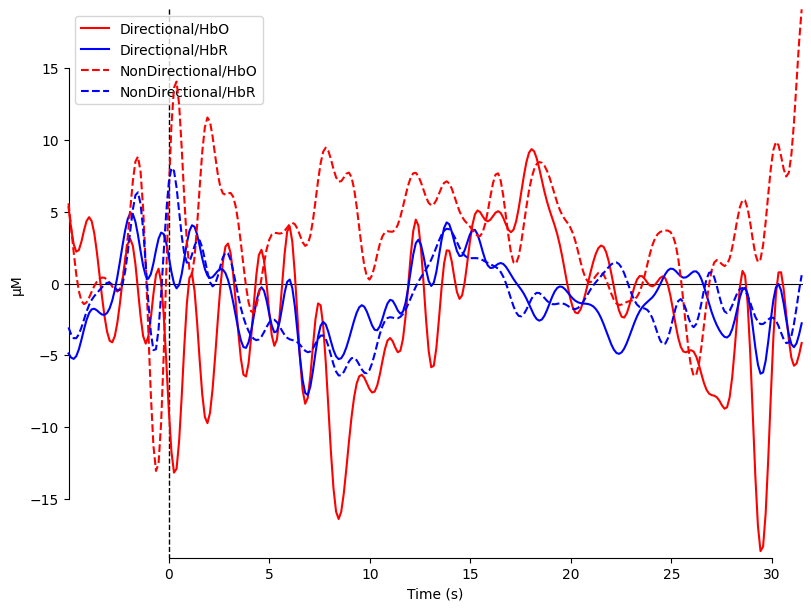

[<Figure size 800x600 with 1 Axes>]

In [39]:
evoked_dict = {'Directional/HbO': epochs['directional'].average(picks='hbo'),
               'Directional/HbR': epochs['directional'].average(picks='hbr'),
               'NonDirectional/HbO': epochs['nondirectional'].average(picks='hbo'),
               'NonDirectional/HbR': epochs['nondirectional'].average(picks='hbr')}

for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO = 'r', HbR = 'b')
styles_dict = dict(NonDirectional = dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine= 'mean',colors=color_dict,styles=styles_dict)

## <a id='step-6-glm'></a>Step 6: GLM design — model specification

Build a design matrix capturing task timing (onsets/durations) and nuisance trends. For block designs, a high-pass filter (cosine drifts) helps remove very slow fluctuations.


## Create design matrix
“The cutoff period (1/high_pass) should be set as the longest period between two trials of the same condition multiplied by 2. For instance, if the longest period is 32s, the high_pass frequency shall be 1/64 Hz ~ 0.016 Hz”.

> **What is a design matrix?** A table of predictor time-courses (task blocks, drifts). Each column is a hypothesis about what drives the data; the GLM tests their weights (betas).


In [40]:
# pip install nilearn pandas numpy
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd
import numpy as np

# --- Pick one preprocessed Raw to build a GLM design matrix ---
# 'pps' should be a list of MNE Raw objects (e.g., haemo_bp) with .annotations set.
if not pps:
    raise RuntimeError("pps is empty — ensure you appended haemo_bp objects.")
raw_haemo = random.choice(pps)  # pick one subject/session at random

# --- Sanity check: annotations are needed to define events ---
if not raw_haemo.annotations or len(raw_haemo.annotations) == 0:
    print("Warning: this Raw has no annotations. GLM design will be empty.")

# --- Grab basic metadata ---
subj_id = raw_haemo.info['subject_info']['his_id']   # your subject identifier
sfreq = raw_haemo.info['sfreq']                      # sampling frequency (Hz)
n_samples = raw_haemo.n_times                        # number of samples in Raw

# --- Frame times (one per sample), in seconds ---
frame_times = np.arange(n_samples) / sfreq

# --- Convert MNE annotations to a Nilearn-friendly events table ---
# Nilearn expects columns: onset (s), duration (s), and trial_type (string).
annot = raw_haemo.annotations
event_list = []

for onset, duration, label in zip(annot.onset, annot.duration, annot.description):
    event_list.append({
        "onset": onset,          # seconds from the Raw time zero
        "duration": duration,    # seconds
        "trial_type": label      # e.g., 'directional', 'nondirectional'
    })

events_df = pd.DataFrame(event_list)

# --- Build the GLM design matrix ---
# drift_model='cosine' adds low-frequency regressors; 'high_pass' is the cutoff frequency (Hz).
# Example uses ~1/(63*2) Hz to high-pass a ~63 s block (adjust to your task timing).
# hrf_model='spm' supplies the canonical HRF; ok for demonstration, but for fNIRS
# you may prefer custom regressors (e.g., FIR/stim-convolved with fNIRS-specific IRF).
design_matrix = make_first_level_design_matrix(
    frame_times=frame_times,   # times (s) matching your data samples
    events=events_df,          # events with onset/duration/trial_type
    drift_model="cosine",
    high_pass=1 / (63 * 2),    # Hz; tune to your block/task structure
    hrf_model="spm"
)


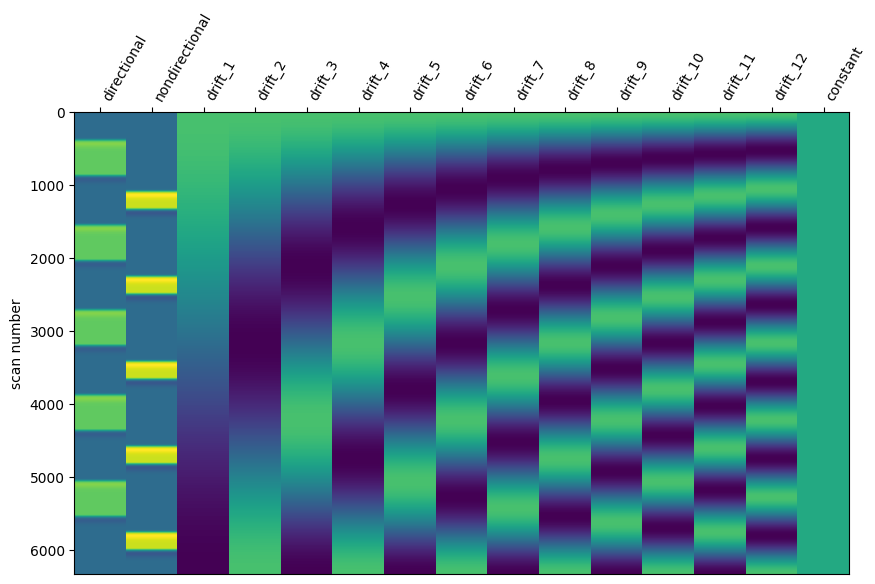

In [41]:
fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=False)
fig = plot_design_matrix(design_matrix, axes=ax1)
plt.show()

In [42]:
data_subset = raw_haemo.copy().pick(picks=range(2))
glm_est = run_glm(data_subset, design_matrix)
glm_est.to_dataframe().head(12)


variable    Condition    df           mse   p_value        se         t  \
0            constant  15.0  2.313865e-08  0.958585  0.000008 -0.052804   
1         directional  15.0  2.313865e-08  0.866854  0.000019 -0.170553   
2             drift_1  15.0  2.313865e-08  0.332892  0.000317 -1.000594   
3            drift_10  15.0  2.313865e-08  0.606776  0.000403 -0.525709   
4            drift_11  15.0  2.313865e-08  0.588463  0.000799 -0.552921   
5            drift_12  15.0  2.313865e-08  0.683018  0.000346 -0.416396   
6             drift_2  15.0  2.313865e-08  0.567856  0.000311 -0.584067   
7             drift_3  15.0  2.313865e-08  0.331197  0.000317 -1.004224   
8             drift_4  15.0  2.313865e-08  0.565354  0.000311 -0.587887   
9             drift_5  15.0  2.313865e-08  0.332283  0.000318 -1.001897   
10            drift_6  15.0  2.313865e-08  0.565362  0.000314 -0.587875   
11            drift_7  15.0  2.313865e-08  0.337907  0.000321 -0.989934   

variable         theta  Source  Detector Chroma  Significant    ch_name  
0        -4.062955e-07       1         1    hbo        False  S1_D1 hbo  
1        -3.283709e-06       1         1    hbo        False  S1_D1 hbo  
2        -3.170853e-04       1         1    hbo        False  S1_D1 hbo  
3        -2.119143e-04       1         1    hbo        False  S1_D1 hbo  
4        -4.415571e-04       1         1    hbo        False  S1_D1 hbo  
5        -1.440953e-04       1         1    hbo        False  S1_D1 hbo  
6        -1.816739e-04       1         1    hbo        False  S1_D1 hbo  
7        -3.179039e-04       1         1    hbo        False  S1_D1 hbo  
8        -1.830059e-04       1         1    hbo        False  S1_D1 hbo  
9        -3.183670e-04       1         1    hbo        False  S1_D1 hbo  
10       -1.846128e-04       1         1    hbo        False  S1_D1 hbo  
11       -3.180347e-04       1         1    hbo        False  S1_D1 hbo

In [43]:
glm_est #the estimated model parameters and statistical outputs after applying the design matrix to your data.

GLM Results for 2 channels

<Axes: xlabel='Condition', ylabel='Theta'>

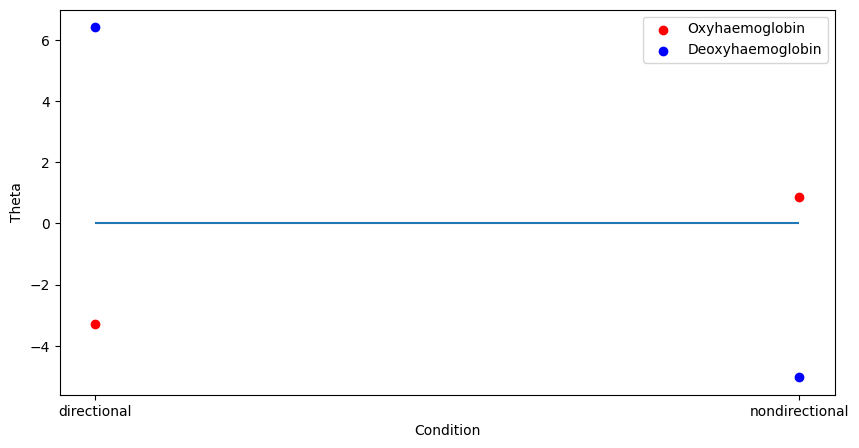

In [44]:
glm_est.scatter()

In [45]:
glm_est.copy().pick("S1_D1 hbr")

GLM Results for 1 channels

In [46]:
glm_est.MSE() ## Mean squared error of residuals

[np.float64(2.313864719164504e-08), np.float64(1.564407629316264e-08)]

In [47]:
glm_est.copy().pick("S1_D1 hbr").MSE()

[np.float64(1.564407629316264e-08)]

<Axes: xlabel='Condition', ylabel='Theta'>

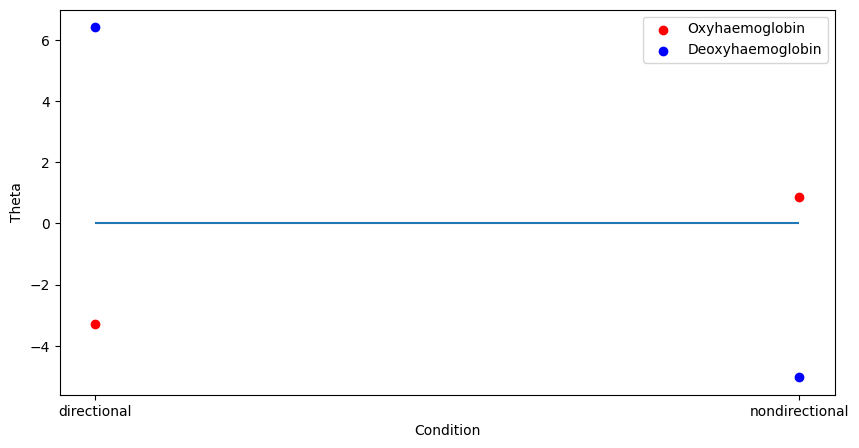

In [48]:
glm_est.scatter()

In [49]:
design_matrix

directional  nondirectional   drift_1   drift_2   drift_3   drift_4  \
0.000            0.0             0.0  0.017775  0.017775  0.017775  0.017775   
0.128            0.0             0.0  0.017775  0.017775  0.017775  0.017775   
0.256            0.0             0.0  0.017775  0.017775  0.017775  0.017775   
0.384            0.0             0.0  0.017775  0.017775  0.017775  0.017775   
0.512            0.0             0.0  0.017775  0.017775  0.017775  0.017774   
...              ...             ...       ...       ...       ...       ...   
809.600          0.0             0.0 -0.017775  0.017775 -0.017775  0.017774   
809.728          0.0             0.0 -0.017775  0.017775 -0.017775  0.017775   
809.856          0.0             0.0 -0.017775  0.017775 -0.017775  0.017775   
809.984          0.0             0.0 -0.017775  0.017775 -0.017775  0.017775   
810.112          0.0             0.0 -0.017775  0.017775 -0.017775  0.017775   

          drift_5   drift_6   drift_7   drift_8   drift_9  drift_10  drift_11  \
0.000    0.017775  0.017775  0.017775  0.017775  0.017775  0.017775  0.017775   
0.128    0.017775  0.017775  0.017775  0.017775  0.017775  0.017775  0.017775   
0.256    0.017775  0.017775  0.017774  0.017774  0.017774  0.017774  0.017773   
0.384    0.017774  0.017774  0.017774  0.017773  0.017773  0.017772  0.017772   
0.512    0.017774  0.017774  0.017773  0.017772  0.017772  0.017771  0.017770   
...           ...       ...       ...       ...       ...       ...       ...   
809.600 -0.017774  0.017774 -0.017773  0.017772 -0.017772  0.017771 -0.017770   
809.728 -0.017774  0.017774 -0.017774  0.017773 -0.017773  0.017772 -0.017772   
809.856 -0.017775  0.017775 -0.017774  0.017774 -0.017774  0.017774 -0.017773   
809.984 -0.017775  0.017775 -0.017775  0.017775 -0.017775  0.017775 -0.017775   
810.112 -0.017775  0.017775 -0.017775  0.017775 -0.017775  0.017775 -0.017775   

         drift_12  constant  
0.000    0.017775       1.0  
0.128    0.017774       1.0  
0.256    0.017773       1.0  
0.384    0.017771       1.0  
0.512    0.017769       1.0  
...           ...       ...  
809.600  0.017769       1.0  
809.728  0.017771       1.0  
809.856  0.017773       1.0  
809.984  0.017774       1.0  
810.112  0.017775       1.0  

[6330 rows x 15 columns]

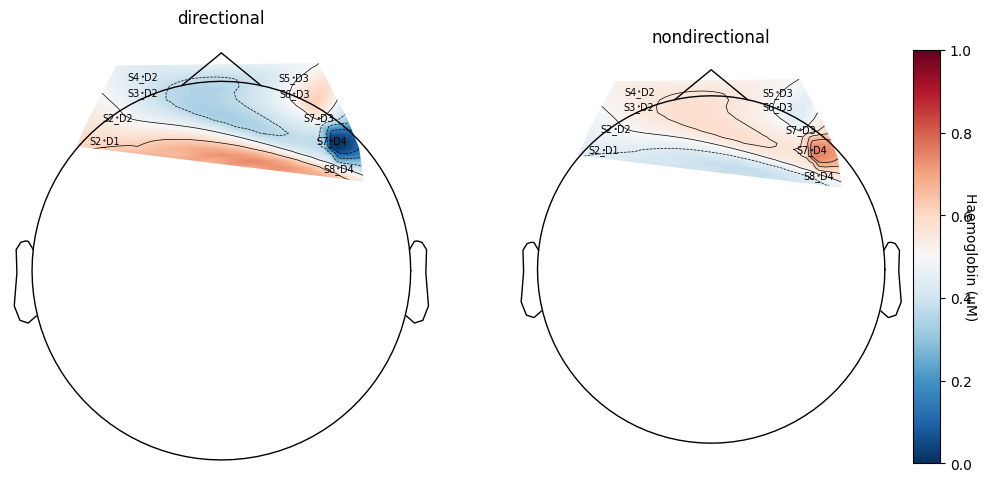

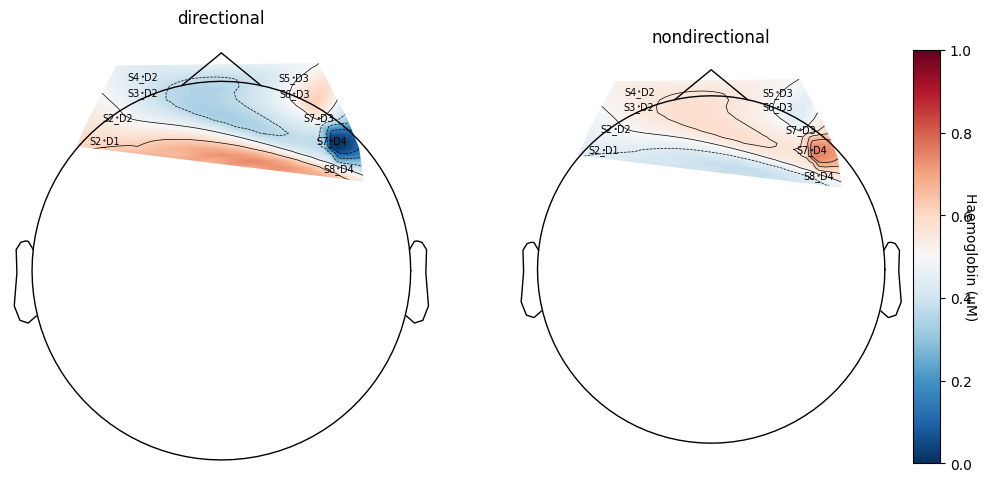

In [50]:
import numpy as np
import mne
from mne_nirs.statistics import run_glm

# 0) sanity: make sure conditions exist in the design matrix
needed = {"directional", "nondirectional"}
have = set(design_matrix.columns)
missing = needed - have
if missing:
    raise ValueError(f"Design matrix missing columns: {missing}. "
                     f"Got: {sorted(have)}")

# 1) find channels with valid positions (both src/det known) and not bad
def has_pos(ch):
    loc = ch["loc"]
    # for fNIRS, src and det positions are stored in loc[3:6] and loc[6:9]
    return not (np.allclose(loc[3:6], 0) and np.allclose(loc[6:9], 0))

good_pos_idx = [i for i, ch in enumerate(raw_haemo.info["chs"]) if has_pos(ch)]
good_types = mne.pick_types(raw_haemo.info, fnirs=True,  exclude="bads")  # include hbo/hbr
good_picks = sorted(set(good_pos_idx).intersection(good_types))

if len(good_picks) == 0:
    raise RuntimeError("No fNIRS channels with valid positions found. "
                       "Check your montage/dig points or SNIRF metadata.")

# (optional) restrict to HbO only for clarity
hbo_picks = mne.pick_types(raw_haemo.info, fnirs="hbo", exclude="bads")
good_picks = sorted(set(good_picks).intersection(hbo_picks)) or good_picks

# 2) run GLM on the subset that has topo coords
raw_for_glm = raw_haemo.copy().pick(good_picks)
glm_est = run_glm(raw_for_glm, design_matrix)

# 3) plot topography for your conditions
glm_est.plot_topo(conditions=["directional", "nondirectional"])


Used Annotations descriptions: [np.str_('directional'), np.str_('nondirectional')]


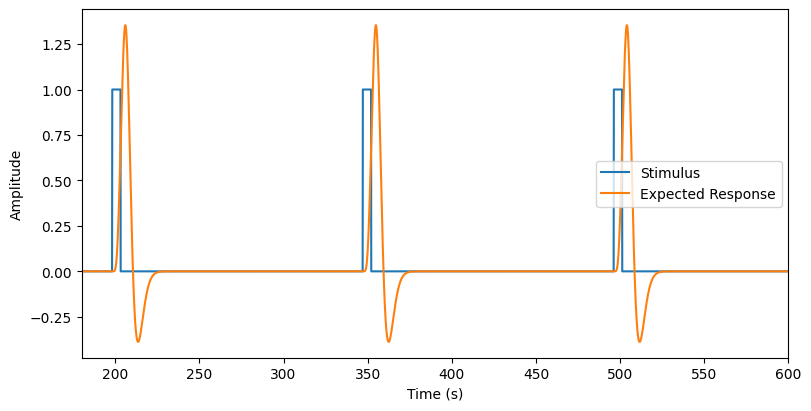

In [51]:
import matplotlib.pyplot as plt
import mne
import mne_nirs

# Pick one random participant from your loaded scans
import random
raw = random.choice(scans)

# --- 1) Create the stimulus boxcar for that participant ---
s = mne_nirs.experimental_design.create_boxcar(raw, stim_dur=5.0)

# --- 2) Build a simple design matrix (optional but useful if you have annotations)
design_matrix = mne_nirs.experimental_design.make_first_level_design_matrix(raw, stim_dur=5.0)

# --- 3) Plot both stimulus and model response ---
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(raw.times, s[:, 0], label="Stimulus")  # use the first column of s
if "directional" in design_matrix.columns:
    ax.plot(design_matrix["directional"], label="Expected Response")

ax.legend()
ax.set(xlim=(180, 600), xlabel="Time (s)", ylabel="Amplitude")
plt.show()


In [52]:
pps

[<RawSNIRF | 1202.snirf, 20 x 6353 (813.2 s), ~1018 KiB, data loaded>,
 <RawSNIRF | 1139.snirf, 20 x 6330 (810.2 s), ~1014 KiB, data loaded>,
 <RawSNIRF | 1264.snirf, 20 x 6260 (801.3 s), ~1003 KiB, data loaded>,
 <RawSNIRF | 1126.snirf, 20 x 6553 (838.8 s), ~1.0 MiB, data loaded>,
 <RawSNIRF | 1253.snirf, 20 x 6217 (795.8 s), ~996 KiB, data loaded>]

In [53]:
glm_est.copy().surface_projection(
    condition="directional", view="lateral", chroma="hbo"
)

In [54]:
glm_est.copy().surface_projection(
    condition="nondirectional", view="lateral", chroma="hbo"
)

In [55]:
print(raw_haemo.ch_names)

['S1_D1 hbo', 'S1_D1 hbr', 'S2_D1 hbo', 'S2_D1 hbr', 'S2_D2 hbo', 'S2_D2 hbr', 'S3_D2 hbo', 'S3_D2 hbr', 'S4_D2 hbo', 'S4_D2 hbr', 'S5_D3 hbo', 'S5_D3 hbr', 'S6_D3 hbo', 'S6_D3 hbr', 'S7_D3 hbo', 'S7_D3 hbr', 'S7_D4 hbo', 'S7_D4 hbr', 'S8_D4 hbo', 'S8_D4 hbr']


In [56]:
import re
from mne_nirs.channels import picks_pair_to_idx

# 1) Build ROIs from pairs that exist in your data
left_pairs  = [(1,1), (2,1), (2,2), (3,2), (4,2)]
right_pairs = [(5,3), (6,3), (7,3), (7,4), (8,4)]

# 2) IMPORTANT: build indices against the GLM's info (matches glm_est data order)
info_glm = glm_est.info

# (optional) make sure these pairs exist (and e.g., HbO is present) before indexing
def available_pairs(info, hemo="hbo"):
    pairs = set()
    for ch in info["chs"]:
        m = re.match(r"S(\d+)_D(\d+)\s+(hbo|hbr)$", ch["ch_name"])
        if m and m.group(3).lower() == hemo:
            pairs.add((int(m.group(1)), int(m.group(2))))
    return pairs

avail_hbo = available_pairs(info_glm, hemo="hbo")

# Filter lists to valid pairs for the hemoglobin you modeled
left_valid  = [p for p in left_pairs  if p in avail_hbo]
right_valid = [p for p in right_pairs if p in avail_hbo]

# 3) Build groups
groups = dict(
    Left_ROI  = picks_pair_to_idx(info_glm, left_valid),
    Right_ROI = picks_pair_to_idx(info_glm, right_valid),
)

# 4) Conditions must match your design_matrix columns
conditions = ["directional", "nondirectional"]

# 5) ROI summary
df = glm_est.to_dataframe_region_of_interest(groups, conditions)
print(df.head())


         ROI       Condition Chroma         theta         se         t  dfe  \
0   Left_ROI     directional    hbo -7.877121e-07  20.351862 -0.038705   15   
1  Right_ROI     directional    hbo -3.036267e-06  13.661922 -0.222243   15   
0   Left_ROI  nondirectional    hbo  3.050238e-07  15.558530  0.019605   15   
1  Right_ROI  nondirectional    hbo  1.269179e-06  10.379161  0.122281   15   

          p                Weighted  
0  0.969636  Inverse standard error  
1  0.827122  Inverse standard error  
0  0.984617  Inverse standard error  
1  0.904299  Inverse standard error  


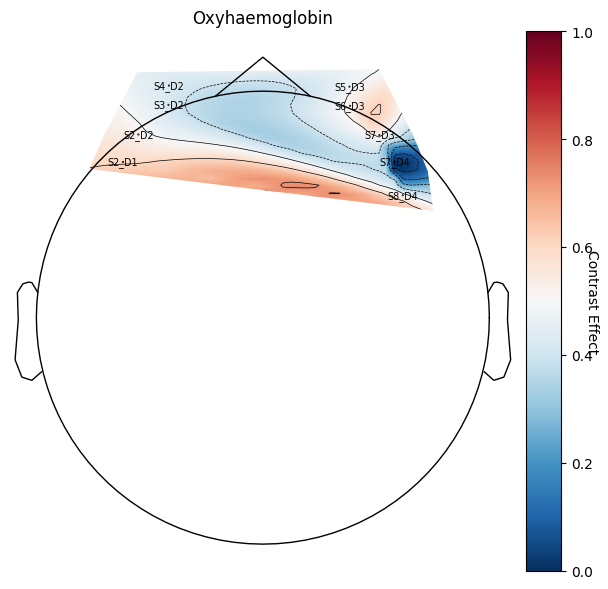

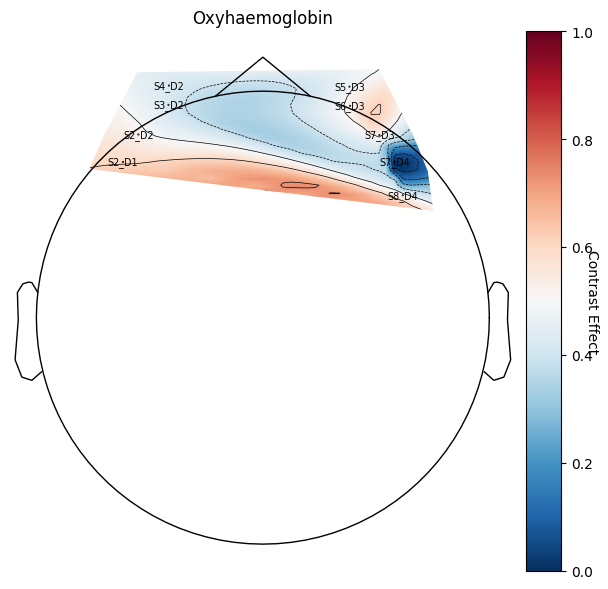

In [57]:
import numpy as np
import re

# Always use the design actually used by the GLM:
X = glm_est.design
cols = list(X.columns)

# Helper: indices for columns that belong to a condition
# e.g., matches "directional", "directional_deriv", etc. if present
def cond_idx(pattern):
    return [i for i, c in enumerate(cols) if re.match(pattern, c)]

dir_idx  = cond_idx(r"^directional(\b|_)")
nond_idx = cond_idx(r"^nondirectional(\b|_)")

if not dir_idx:
    raise ValueError(f"'directional' not found in GLM design columns: {cols}")
if not nond_idx:
    raise ValueError(f"'nondirectional' not found in GLM design columns: {cols}")

# Build a t-contrast vector of length P = X.shape[1]
c = np.zeros(len(cols), float)

# If multiple regressors per condition (e.g., derivatives), weight them equally
c[dir_idx]   =  +1.0 / len(dir_idx)
c[nond_idx]  =  -1.0 / len(nond_idx)

# Compute and plot
contrast = glm_est.compute_contrast(c, contrast_type="t")
contrast.plot_topo()


In [58]:
df = glm_est.to_dataframe()

df

variable       Condition    df           mse   p_value        se         t  \
0               constant  15.0  1.865139e-09  0.175128  0.000010 -1.423258   
1            directional  15.0  1.865139e-09  0.321288  0.000024  1.025706   
2                drift_1  15.0  1.865139e-09  0.122335  0.000402  1.637467   
3               drift_10  15.0  1.865139e-09  0.404701  0.000499 -0.857426   
4               drift_11  15.0  1.865139e-09  0.094097  0.000979  1.787365   
..                   ...   ...           ...       ...       ...       ...   
130              drift_6  15.0  8.085573e-10  0.396330  0.000260 -0.873178   
131              drift_7  15.0  8.085573e-10  0.428122  0.000268  0.814463   
132              drift_8  15.0  8.085573e-10  0.442934  0.000267 -0.788068   
133              drift_9  15.0  8.085573e-10  0.473718  0.000277  0.734928   
134       nondirectional  15.0  8.085573e-10  0.708244  0.000012 -0.381415   

variable     theta  Source  Detector Chroma  Significant    ch_name  
0        -0.000014       2         1    hbo        False  S2_D1 hbo  
1         0.000024       2         1    hbo        False  S2_D1 hbo  
2         0.000658       2         1    hbo        False  S2_D1 hbo  
3        -0.000428       2         1    hbo        False  S2_D1 hbo  
4         0.001750       2         1    hbo        False  S2_D1 hbo  
..             ...     ...       ...    ...          ...        ...  
130      -0.000227       8         4    hbo        False  S8_D4 hbo  
131       0.000218       8         4    hbo        False  S8_D4 hbo  
132      -0.000211       8         4    hbo        False  S8_D4 hbo  
133       0.000204       8         4    hbo        False  S8_D4 hbo  
134      -0.000005       8         4    hbo        False  S8_D4 hbo  

[135 rows x 12 columns]